# MC Focus Group - 31/10/17

We're currently studying MD integration algorithms, so that we can understand their application to HMC algorithms, and others...

In [1]:
import numpy
from matplotlib import pyplot
from numba import jit

Consider the harmonic oscillator (2D phase space):

$U(x) = \frac{1}{2}kx^2$

$K(p) = \frac{p^2}{2m}$

$H(x, p) = U(x) + K(p)$


Implementation of Langevin MD for this example:
- Initialise system
- Calculate $F=-\frac{dU}{dx}$
- Calculate random factor
- Update position & momentum
- Calculate total energy
- Plot point in phase space

We define the relevant functions below...

In [2]:
def potential_energy(x, k):
    """
    Harmonic oscillator potential energy
    """
    return 0.5 * k * numpy.square(x)

def kinetic_energy(p, m):
    """
    Harmonic oscillator kinetic energy
    """
    return numpy.square(p) / (2 * m)

def total_energy(x, p, k, m):
    """
    Harmonic oscillator total energy
    """
    return potential_energy(x, k) + kinetic_energy(p, m)

def force(x, k):
    """
    Calculate force on harmonic oscillator with position x
    """
    return - k * x

@jit
def baoab(inital, k=1, m=1, gamma=1, T=1, nsteps=100, dt=0.002):
    """
    Propagate an initial point (x, p) through phase space for nsteps with timestep dt, using BAOAB Langevin MD
    """
    xi, pi = initial
    total_energies = [total_energy(xi, pi, k, m)]
    potential_energies = [potential_energy(xi, k)]
    kinetic_energies = [kinetic_energy(pi, m)]
    xs = [xi]
    ps = [pi]
    c1 = numpy.exp(-gamma*dt)
    c3 = numpy.sqrt(T*(1-numpy.square(c1)))
    for i in range(nsteps):
        x_0 = xs[-1]
        p_0 = ps[-1]
        # Deterministic momentum update
        p_1_2 = p_0 + 0.5*dt*force(x_0,k)
        # Position update
        x_1_2 = x_0 + 0.5*dt*p_1_2/m
        # Stochastic momentum update
        p_1_2_ = p_1_2*c1 + c3*numpy.sqrt(m)*numpy.random.normal()
        # Position update
        x_1 = x_1_2 + 0.5*dt*p_1_2_/m
        # Deterministic momentum update
        p_1 = p_1_2_ + 0.5*dt*force(x_1,k)
        total_energies.append(total_energy(x_1, p_1, k, m))
        potential_energies.append(potential_energy(x_1, k))
        kinetic_energies.append(kinetic_energy(p_1, m))
        xs.append(x_1)
        ps.append(p_1)
    return xs, ps, total_energies, potential_energies, kinetic_energies

With these functions defined, we can now run some short MD of the harmonic oscillator, for a given position and momentum:

In [3]:
initial = (1, 0)
xtraj, ptraj, h, u, k = baoab(initial, nsteps=int(2e5), dt=0.1)

We can then plot the phase space sampled during this trajectory:

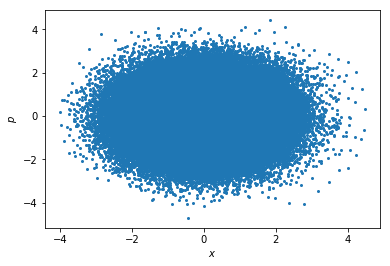

In [4]:
pyplot.plot(xtraj, ptraj, 'o', markersize=2, linewidth=0)
pyplot.xlabel("$x$")
pyplot.ylabel("$p$")
pyplot.show()

We know the probability distributions of the positions and momenta for this system:

$$\rho(x) = \exp\left(\frac{-E_p}{k_B T}\right)=\exp\left(\frac{-kx^2}{2k_B T}\right)$$

$$\rho(p) = \exp\left(\frac{-E_k}{k_B T}\right)=\exp\left(\frac{-p^2}{2mk_B T}\right)$$

Therefore, we can compare the observed distributions to the distributions that should be observed for the canonical (NVT) ensemble.

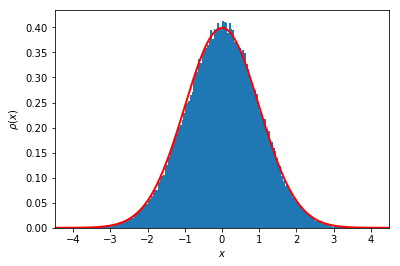

In [5]:
xlin = numpy.linspace(-5, 5, 500)
gx = numpy.exp(-numpy.square(xlin)/2)/numpy.sqrt(2*numpy.pi)
pyplot.hist(xtraj, bins='auto', normed=True)
pyplot.plot(xlin, gx, '-', color='red', linewidth=2.0)
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$\rho(x)$")
pyplot.xlim(-4.5, 4.5)
pyplot.show()

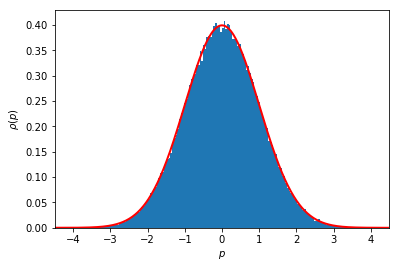

In [6]:
plin = numpy.linspace(-5, 5, 500)
gp = numpy.exp(-numpy.square(xlin)/2)/numpy.sqrt(2*numpy.pi)
pyplot.hist(ptraj, bins='auto', normed=True)
pyplot.plot(plin, gp, '-', color='red', linewidth=2.0)
pyplot.xlabel(r"$p$")
pyplot.ylabel(r"$\rho(p)$")
pyplot.xlim(-4.5, 4.5)
pyplot.show()

To-do list:
- Study Trotter formalism for momentum updates ($e^{\delta t L_B}$) - What does it operate on and how?
- How do we derive the operator ($L_B$)?
- How do we construct integrators using Trotter formalism?
- Can we show equivalence between different sequences?
- Does the integrator contain the ensemble info?